In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # put -1 to not use any

# import sys
# sys.path.append('segment-anything')

In [2]:
import torch

In [3]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/lumargot/.cache/torch/hub/main.zip
/home/lumargot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lumargot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lumargot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/lumargot/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:10<00:00, 114MB/s] 


In [4]:
# import numpy as np
# import pandas as pd 
# import os 
# import matplotlib.pyplot as plt
import os 
import cv2
# import torch
# from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
# import SimpleITK as sitk

In [17]:
img = cv2.imread('/CMF/data/lumargot/hysterectomy/frames/Cuff_Closure/Cuff_Closure_Hyst_BB_1.20.23a_1150.png')
img = cv2.resize(img, (224,224))

In [18]:
import matplotlib.pyplot as plt 

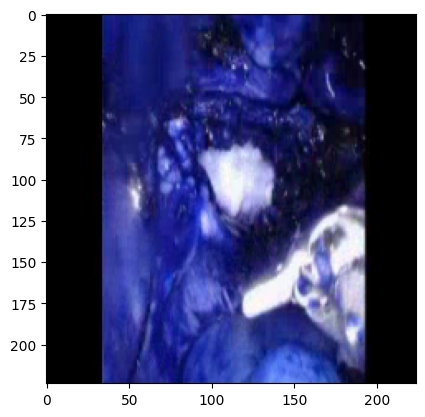

In [19]:
plt.imshow(img)

In [20]:
img_reshape = torch.from_numpy(img).unsqueeze(0)

In [23]:
img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()

In [24]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [26]:
out = dinov2_vitl14(img_tensor)

In [27]:
out.shape

torch.Size([1, 1024])

## hysterectomy Data

In [4]:
CHECKPOINT_PATH='ckp/sam/sam_vit_h_4b8939.pth'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint=CHECKPOINT_PATH).to(device=device)
mask_predictor = SamPredictor(sam)

In [ ]:
ref_vid_dir = os.path.join(DATA_DIR, 'Reference_Videos/')


for vid_name in os.listdir(ref_vid_dir):
    
    vid_dir = os.path.join(ref_vid_dir, vid_name)
    vid_csv = os.path.join(DATA_DIR,  vid_name + '_InstrumentAnnotations.csv')

    df = pd.read_csv(vid_csv)

    if not os.path.isdir(vid_dir):
        targets = [vid_dir]
    else:
        targets = []
        for frame_n in os.listdir(vid_dir):
            img = os.path.join(vid_dir, frame_n, '0/images',  frame_n+ '.png')
            targets.append(img)

    df_mask = []
    i=0

    for t in targets:
        print(f"Processing '{t}' : idx {i} / {len(targets)}")
        i+=1
        base = os.path.basename(t)
        frame_n = os.path.splitext(base)[0]

        image = cv2.imread(t)
        h,w = image.shape[:2] 
        if image is None:
            print(f"Could not load '{t}' as an image, skipping...")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        df_img = df.loc[df['Frame']==int(frame_n)]
        
        save_base = t.split('images')[0]
        # save_base = os.path.join(args.output, base)

        save_base = os.path.join(save_base, 'binary_annotations')
        list_bbx = []
        
        os.makedirs(save_base, exist_ok=True)
        for idx, row in df_img.iterrows():

            x1 = max(row['XTL'], 0)
            y1 = max(row['YTL'], 0)

            x2 = min(row['XBR'], w)
            y2 = min(row['YBR'], h)

            label = row['Label']

            bbx = np.array([x1, y1, x2, y2])

            mask_predictor.set_image(image)
            masks, scores, logits = mask_predictor.predict(box = bbx, multimask_output=False, point_coords=None, point_labels=None)
            mask = masks[0,...].astype(int)

            filename = os.path.join(save_base, f"{frame_n}_class{label}.png")  

            cv2.imwrite(filename, mask * 255)
            